In [ ]:
!pip install -r requirements.txt

In [ ]:
import numpy as np 
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/netflix-reviews-playstore-daily-updated/netflix_reviews.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
import re
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout



2024-05-23 18:12:50.700876: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-23 18:12:50.701053: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-23 18:12:50.838539: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [3]:
netflix_reviews_df = pd.read_csv('/kaggle/input/netflix-reviews-playstore-daily-updated/netflix_reviews.csv')
netflix_reviews_df.drop(columns = ['reviewId','userName','reviewCreatedVersion','at','appVersion'],inplace = True)
netflix_reviews_df.head()

,content,score,thumbsUpCount
0,Where it's me on the plane. It's good. You can...,5,0
1,I have an account for 5 users that I share wit...,1,1
2,Can never go a day without Netflix 😎,5,0
3,And another streaming service that I'm not gon...,1,1
4,Cannot cast if you have ad level plan. Worthless,1,0


<h3>Data Processing</h3>

In [ ]:
import emoji
def de_emojize_text(text):
    for x in text: # If a text contains an emoji, convert that emoji into its english name
        if emoji.is_emoji(x):
            demojized = emoji.demojize(x).split("_")
            demojized_string = " ".join(demojized)
            text = text.replace(x, demojized_string)
    return text

In [ ]:
def preprocess_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r'<.*?>', '', text)  # remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    text = re.sub(r'\d+', '', text)  # remove numbers
    return text

# Apply Function
netflix_reviews_df['cleaned_content'] = netflix_reviews_df['content'].astype(str).apply(de_emojize_text).apply(preprocess_text)


<h3>Feature Extraction</h3>


In [5]:
# Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform the cleaned text data
X = vectorizer.fit_transform(netflix_reviews_df['cleaned_content'])


<h3>Sentiment Analysis Model</h3>

In [ ]:
def score_to_sentiment(score):
    if score <= 2:
        return 'negative'
    elif score == 3:
        return 'neutral'
    else:
        return 'positive'

# Apply function 
netflix_reviews_df['sentiment'] = netflix_reviews_df['score'].apply(score_to_sentiment)

<h3>Tokenize and Pad Sequences</h3>

In [ ]:
max_len = 100  # Max number of words in a sequence
max_features = 20000
# Tokenize the text
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(netflix_reviews_df['cleaned_content'])
sequences = tokenizer.texts_to_sequences(netflix_reviews_df['cleaned_content'])

# Pad the sequences
X = pad_sequences(sequences, maxlen=max_len)

# Convert sentiments to numerical labels
sentiment_label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
y = netflix_reviews_df['sentiment'].map(sentiment_label_map).values

# Split the data into training, testing, valid sets
X_train, X_valid, y_train, y_valid = train_test_split(netflix_reviews_df['content'],
                                                      netflix_reviews_df['sentiment'],
                                                      test_size=0.1,
                                                      random_state=101)

X_valid, X_test, y_valid, y_test = train_test_split(X_valid,
                                                    y_valid,
                                                    test_size=0.5,
                                                    random_state=101)


<h3>Build and Train the LSTM Model</h3>

In [ ]:
# Define the LSTM model
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_valid, y_valid))

Epoch 1/5
2744/2744 ━━━━━━━━━━━━━━━━━━━━ 440s 159ms/step - accuracy: 0.7694 - loss: 0.5624 - val_accuracy: 0.9127 - val_loss: 0.2611
Epoch 2/5
2744/2744 ━━━━━━━━━━━━━━━━━━━━ 442s 159ms/step - accuracy: 0.9253 - loss: 0.2245 - val_accuracy: 0.9293 - val_loss: 0.2104
Epoch 3/5
2744/2744 ━━━━━━━━━━━━━━━━━━━━ 435s 158ms/step - accuracy: 0.9482 - loss: 0.1515 - val_accuracy: 0.9368 - val_loss: 0.1944
Epoch 4/5
2744/2744 ━━━━━━━━━━━━━━━━━━━━ 441s 158ms/step - accuracy: 0.9602 - loss: 0.1149 - val_accuracy: 0.9336 - val_loss: 0.2048
Epoch 5/5
2744/2744 ━━━━━━━━━━━━━━━━━━━━ 452s 162ms/step - accuracy: 0.9680 - loss: 0.0930 - val_accuracy: 0.9314 - val_loss: 0.2245


<h3>Evaluate the Model</h3>

In [10]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test, batch_size=32)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')


686/686 ━━━━━━━━━━━━━━━━━━━━ 39s 57ms/step - accuracy: 0.9319 - loss: 0.2196
Test Loss: 0.22454869747161865
Test Accuracy: 0.9314225912094116


<h3>Accurancy and Loss</h3>


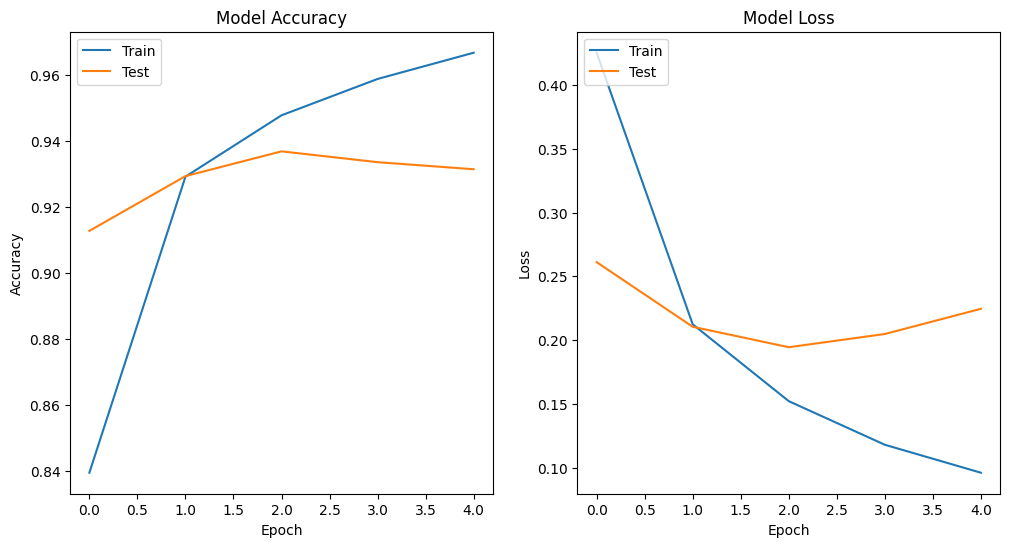

In [12]:

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()


<h3>Sentiment and Score Visulalisation</h3>


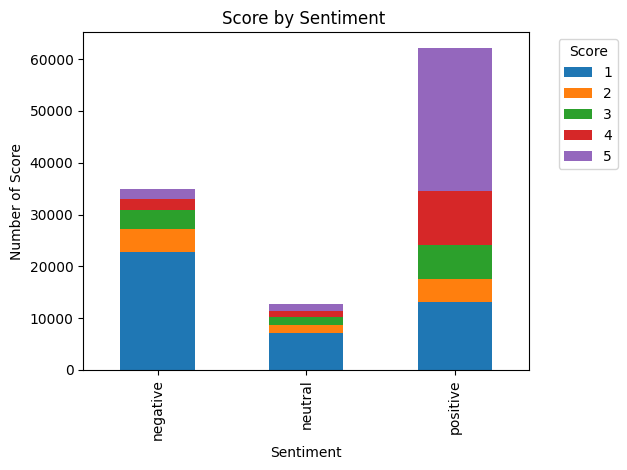

In [13]:


sentiment_score_counts = netflix_reviews_df.groupby(['sentiment', 'score']).size().unstack()
sentiment_score_counts.plot(kind='bar', stacked=True)

plt.title('Score by Sentiment ')
plt.xlabel('Sentiment')
plt.ylabel('Number of Score')
plt.legend(title='Score', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


<h3>Sentiment and Score Percentage</h3>

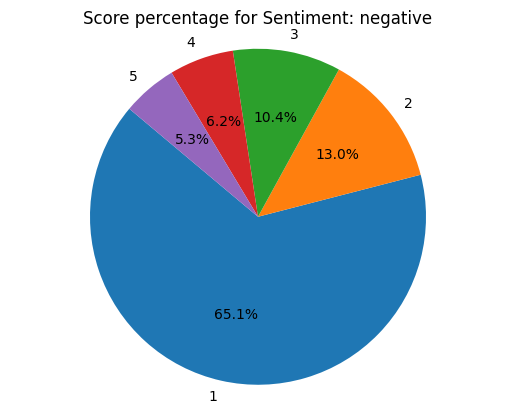

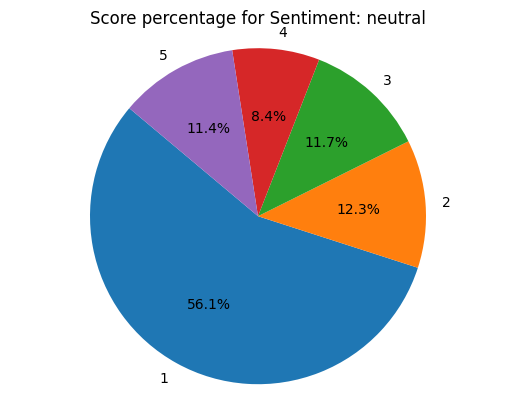

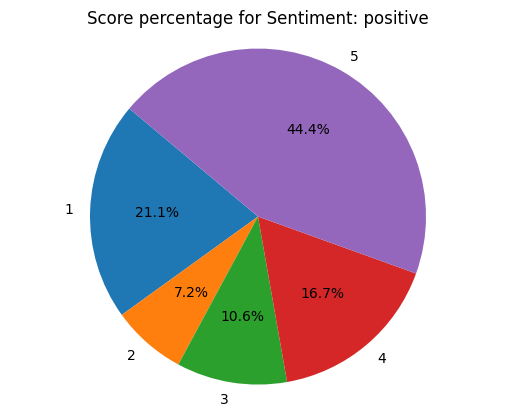

In [14]:
sentiment_score_counts = netflix_reviews_df.groupby(['sentiment', 'score']).size().unstack()

for sentiment in sentiment_score_counts.index:
    sentiment_counts = sentiment_score_counts.loc[sentiment]
    plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(f'Score percentage for Sentiment: {sentiment}')
    plt.axis('equal') 
    plt.show()
